In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import time
from sklearn.metrics import mean_absolute_error

In [2]:
# remove some points with decay
# add progressive parameteres based on likelihood

In [7]:
img = cv2.imread('../print.jpg')/255.0
max_size = 1000
H, W = img.shape[0], img.shape[1]
if H > W:
    if H > max_size:
        img = cv2.resize(img, (int(W * max_size / H)), max_size)
else:
    if W > max_size:
        img = cv2.resize(img, (max_size, int(H * max_size / W)))
        
H, W = img.shape[0], img.shape[1]
padding = int(W * 0.1 if H > W else H * 0.1)
zeros = np.zeros((H + padding * 2, W + padding * 2, 3))
zeros[padding: padding + H, padding: padding + W] = img
img = zeros
mask_img = np.zeros(img.shape)

blurs = dict()
for i in range(1, 100):
    blurs[i] = cv2.blur(img, (i, i))

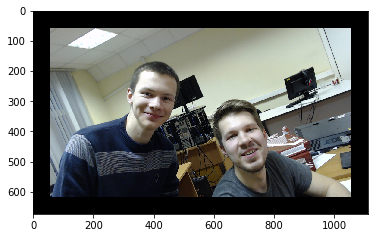

In [8]:
plt.imshow(img[:,:,::-1])

In [9]:
class Stroke():
    def __init__(self, image, dispersion, amount, speed):
        image_size = image.shape[:2]
        self.dispersion = dispersion
        x = np.random.randint(0, image_size[1], 1)
        y = np.random.randint(0, image_size[0], 1)
        self.center = np.concatenate([x, y], axis=0).astype(np.float)
        
        self.particles_angle = np.random.uniform(0, 2 * np.pi, amount)
        self.particles_radius = np.fabs(np.random.normal(0, dispersion*2, amount))
        
        self.angle = np.random.uniform(0, 2 * np.pi)
        self.rotation = np.random.uniform(-np.pi/60, np.pi/60)
        self.color = image[y[0], x[0]]
        self.speed = np.random.normal(speed, speed/3, 1)
        self.status = 'running'
        self.ttl = np.random.normal(3)
        
        
    def get_mean_color(self, image, x, y):
        if 0 < x < image.shape[1] and 0 < y < image.shape[0]:
            return blurs[self.dispersion][int(y), int(x)]
        else:
            return self.color
        
        
    def update(self, image):  
        # add removal of some points
        self.last_center = self.center.copy()
        self.angle += self.rotation
        
        self.center[0] += np.cos(self.angle) * self.speed
        self.center[1] += np.sin(self.angle) * self.speed
        
        self.particles_angle += self.rotation
        mean_color = self.get_mean_color(image, self.center[0], self.center[1])
        self.color = self.color - (self.color - mean_color)/2
        self.ttl -= np.random.uniform(0, 0.05)
        if self.ttl <= 0:
            self.status = 'deleted'
        
        
    def draw(self, image):
        offset_x = np.cos(self.particles_angle) * self.particles_radius
        offset_y = np.sin(self.particles_angle) * self.particles_radius
        positions = (self.center.reshape(2, 1) + [offset_x, offset_y]).T.reshape(-1, 1, 2)
        last_positions = (self.last_center.reshape(2, 1) + [offset_x, offset_y]).T.reshape(-1, 1, 2)
        points = np.concatenate([last_positions, positions], axis=1).astype(np.int32)
        cv2.polylines(image, points, False, self.color, 2)   


In [10]:
max_strokes = 10
min_dispersion = 5
max_dispersion = 18
min_amount = 50
max_amount = 100
max_image_size = max(img.shape[:2])
base_speed = max_image_size/100
strokes = [Stroke(img, 
                  dispersion=np.random.randint(min_dispersion, max_dispersion), 
                  amount=np.random.randint(min_amount, max_amount),
                  speed=base_speed) for _ in range(max_strokes)]
total_img_value = img.sum()
error = 1

while error > 0.12:
    strokes = [st for st in strokes if st.status != 'deleted']
    for _ in range(max_strokes - len(strokes)):
        strokes.append(Stroke(img, 
                              np.random.randint(int(min_dispersion), int(max_dispersion)), 
                              np.random.randint(int(min_amount), int(max_amount)),
                              speed=base_speed))
        
    prev = time.time()
    for st in strokes:
        st.update(img)
        st.draw(mask_img)
    prev = time.time()   
    error = np.abs((img - mask_img)).sum() / total_img_value
    
    min_dispersion = 5 - (4 * (1 - error))
    max_dispersion = 18 - (16 * (1 - error))
    min_amount = 50 - (49 * min((1.1 - error), 1))
    max_amount = 100 - (98 * min((1.1 - error), 1))
    base_speed = max_image_size/100 - (max_image_size/100 * 0.8 * (1 - error))
    max_strokes = int(10 + 90 * (1 - error))
    print('error ',(time.time() - prev)*1000)
    print(error)
    
#     print('update and paint: ',(time.time() - prev)*1000)
        
    cv2.imshow('BlindArtist', mask_img)
    key = cv2.waitKey(1)
    if key == 27:      # esc
        break
        
cv2.destroyAllWindows() 

error  10.996103286743164
0.9860231951594081
error  7.647037506103516
0.9760976173100822
error  5.960702896118164
0.9687792694787745
error  5.94329833984375
0.9622793157875951
error  6.276845932006836
0.9548439804201645
error  5.276679992675781
0.9476603662476323
error  5.813837051391602
0.9412389131304045
error  5.695343017578125
0.9357754799469336
error  6.866455078125
0.9293041418809129
error  7.303953170776367
0.920639318442612
error  7.290840148925781
0.9118346414886312
error  7.324934005737305
0.9035009540964698
error  7.254123687744141
0.893649751322721
error  7.449626922607422
0.8814656398149439
error  8.074760437011719
0.8696575296420505
error  6.47425651550293
0.857660010605168
error  6.27589225769043
0.8457689223340535
error  5.426883697509766
0.8336947371081196
error  6.364583969116211
0.8229791740426897
error  5.533933639526367
0.8127194292933183
error  5.556583404541016
0.8029723940387669
error  5.578756332397461
0.7950510270210096
error  5.471944808959961
0.7862650953351

error  6.836414337158203
0.331085147731926
error  5.727052688598633
0.33090752782449884
error  6.061553955078125
0.3305945079402381
error  6.103515625
0.3299008660096128
error  6.036996841430664
0.3291783299462419
error  5.664825439453125
0.3283823144207714
error  5.846261978149414
0.3275603830533388
error  6.1473846435546875
0.3266531324813962
error  6.143093109130859
0.32603735504430015
error  6.737947463989258
0.32556197692570943
error  5.6552886962890625
0.3251047770236188
error  5.701303482055664
0.32476951842226054
error  7.087230682373047
0.32461181640343484
error  7.730960845947266
0.32452735749605427
error  6.806373596191406
0.3241551007543885
error  6.783962249755859
0.3237996148298661
error  6.825923919677734
0.3234367813342525
error  6.25157356262207
0.32305626198334275
error  6.277799606323242
0.3223538874322051
error  6.284952163696289
0.32163382683907665
error  6.284236907958984
0.3204355319417512
error  6.2618255615234375
0.31941409699403056
error  6.244182586669922
0.3

error  7.148265838623047
0.23168464615052517
error  7.515430450439453
0.23093490294989769
error  6.828546524047852
0.23029015880812792
error  6.285190582275391
0.22981477054211621
error  5.940675735473633
0.22916248427423377
error  5.779027938842773
0.22858950999298258
error  5.780220031738281
0.2280315653699394
error  6.552696228027344
0.2275452459923617
error  5.988836288452148
0.22732770051783968
error  6.171464920043945
0.22711343817362942
error  6.804227828979492
0.22683842142424543
error  6.557941436767578
0.2264328183494264
error  6.677389144897461
0.22604926409845827
error  6.566762924194336
0.2255269124243165
error  5.84864616394043
0.2249082564876166
error  5.748510360717773
0.22444548058545105
error  5.717277526855469
0.2241520861852559
error  5.736112594604492
0.22384312879880466
error  5.693674087524414
0.22335244928779996
error  6.086111068725586
0.22291046189029676
error  6.203651428222656
0.22256064444250825
error  6.254911422729492
0.22222187275818678
error  6.28972053

error  6.832599639892578
0.18087558397729714
error  7.18235969543457
0.1806367583735946
error  5.770683288574219
0.18043547812773525
error  5.7811737060546875
0.1803567657334861
error  5.747079849243164
0.18007040296878
error  5.734443664550781
0.17977734878449275
error  5.744457244873047
0.17954370118426266
error  5.812644958496094
0.17936979787611185
error  5.695819854736328
0.17931265431146612
error  5.721092224121094
0.1792141058674887
error  5.704641342163086
0.17906840015919734
error  5.769014358520508
0.17906193656667857
error  6.201267242431641
0.17898460880409217
error  5.908966064453125
0.17896809349612855
error  6.60252571105957
0.17892202937124413
error  6.7462921142578125
0.17874423107424686
error  6.773233413696289
0.1785842338334107
error  7.550716400146484
0.17856122364312946
error  5.867719650268555
0.1785899393975859
error  5.809545516967773
0.17835025636315927
error  6.213665008544922
0.1782873592748598
error  6.245613098144531
0.1782046540364419
error  6.29162788391

error  7.138729095458984
0.1584309194616621
error  7.854223251342773
0.15823487125977126
error  6.9103240966796875
0.1581018068634585
error  6.890296936035156
0.15798786304881351
error  6.856203079223633
0.15788841607972298
error  5.872011184692383
0.15773778506081698
error  5.852699279785156
0.15760789814759837
error  6.167888641357422
0.15759806020269596
error  6.2694549560546875
0.1574765338351071
error  6.263256072998047
0.15736233484659296
error  6.287574768066406
0.1571339945379718
error  6.281375885009766
0.15694741794146794
error  6.238460540771484
0.156873610347409
error  7.61103630065918
0.15682475157071707
error  6.900548934936523
0.1568052925777188
error  6.913423538208008
0.15681486311432036
error  6.80851936340332
0.15682490763626714
error  6.304502487182617
0.1567368865181711
error  6.237268447875977
0.15662469734203846
error  6.291627883911133
0.15656927732724327
error  6.300449371337891
0.1565419841597152
error  6.275177001953125
0.15656928342807622
error  6.2892436981

error  6.219625473022461
0.14164916275414444
error  5.928516387939453
0.14161654087668854
error  5.820512771606445
0.14143046346180113
error  5.83338737487793
0.14125665470621665
error  6.156682968139648
0.14116408491370322
error  6.194829940795898
0.1410323674513726
error  6.011009216308594
0.14102278321027217
error  6.227731704711914
0.14090959061396938
error  6.31260871887207
0.14076981572689784
error  6.470918655395508
0.14068014947710153
error  6.333827972412109
0.14050265346098748
error  6.376028060913086
0.14036348671368273
error  6.212949752807617
0.14019272536296293
error  7.586956024169922
0.14010671161064808
error  7.622480392456055
0.1399524631728428
error  6.936311721801758
0.13989213922495505
error  7.004022598266602
0.13977913018825927
error  6.718635559082031
0.1397090973856975
error  5.931377410888672
0.13971359788905108
error  6.19959831237793
0.13971162169678825
error  6.226062774658203
0.13957503663842818
error  6.241798400878906
0.13949425951783626
error  6.3083171

error  8.965492248535156
0.13078492697785898
error  7.111310958862305
0.13063972129094914
error  6.931543350219727
0.13063930777690297
error  6.958723068237305
0.13057393687383562
error  6.390810012817383
0.1305325896349527
error  6.351470947265625
0.13044050723345677
error  6.328105926513672
0.1304043040765307
error  6.382226943969727
0.13044113777104777
error  6.281137466430664
0.1304345857487063
error  6.079673767089844
0.13041914457286818
error  5.948066711425781
0.13039952669310237
error  5.8078765869140625
0.13038351389698655
error  5.7926177978515625
0.13039681825589805
error  7.540464401245117
0.13036592730459473
error  5.866289138793945
0.13029181096765716
error  8.216619491577148
0.13028262775351573
error  5.83958625793457
0.13016626501299766
error  5.81049919128418
0.1300304092430422
error  5.820989608764648
0.13004219330288883
error  6.274700164794922
0.1300520363571863
error  6.276130676269531
0.13003369630254566
error  6.290435791015625
0.12999021591239052
error  6.404876

error  7.310628890991211
0.12442536296565769
error  5.881309509277344
0.12432735325892129
error  5.8002471923828125
0.12425585553908018
error  5.847692489624023
0.12416602521740111
error  5.834341049194336
0.12409949178541561
error  5.74803352355957
0.12402883658000148
error  5.739927291870117
0.12399794485865831
error  5.754709243774414
0.12395797355170432
error  5.79071044921875
0.12393612679449796
error  5.761861801147461
0.12385799715594786
error  6.257295608520508
0.12381647896337988
error  6.34455680847168
0.1237991720106559
error  6.359577178955078
0.12376267802189317
error  7.038593292236328
0.12371629418545127
error  7.177114486694336
0.12372847165840739
error  6.99162483215332
0.12366009159276835
error  7.002115249633789
0.123604833955256
error  5.817651748657227
0.12355545213366174
error  5.826711654663086
0.12344034065921526
error  5.765438079833984
0.12338006555344146
error  5.757808685302734
0.12337405894191661
error  6.27446174621582
0.12330759256606778
error  6.29162788

error  6.74128532409668
0.11715428108654763
error  7.536172866821289
0.11714233880776169
error  7.019519805908203
0.11712290821838643
error  7.068395614624023
0.11707065723560812
error  6.892919540405273
0.1170129645375134
error  5.937099456787109
0.11699996074130259
error  6.23631477355957
0.1170179041465211
error  6.404638290405273
0.11701334691375205
error  6.366729736328125
0.11699444709582761
error  6.3877105712890625
0.11696577930475606
error  6.365776062011719
0.11697413265891139
error  6.335735321044922
0.11697004794323494
error  6.301641464233398
0.11695510873407436
error  8.798599243164062
0.11693803433357719
error  7.040500640869141
0.11693299247943316
error  6.9599151611328125
0.11689331253293085
error  6.962060928344727
0.11686799462884341
error  6.414890289306641
0.11688516541111157
error  6.419658660888672
0.11688429367474144
error  6.392717361450195
0.11689601400219463
error  6.273984909057617
0.11687452599835599
error  6.451606750488281
0.11682440484625588
error  5.932

error  7.325649261474609
0.11301027600994923
error  6.768465042114258
0.11298457856991075
error  6.974697113037109
0.11298334382848942
error  6.987571716308594
0.1129423044033614
error  6.895303726196289
0.11295609719685715
error  7.540464401245117
0.11291621989960883
error  5.858898162841797
0.11292162736522685
error  5.809545516967773
0.11290154662183016
error  5.875825881958008
0.11288874150336377
error  5.760908126831055
0.11284774452182265
error  5.85484504699707
0.11286958709752222
error  5.764484405517578
0.11282926924345028
error  6.009817123413086
0.11277073082968556
error  6.052255630493164
0.11269844442507759
error  6.678342819213867
0.11260739097814713
error  6.890535354614258
0.11260044241996309
error  6.88481330871582
0.11257858795417071
error  6.921529769897461
0.11257892785915391
error  6.353139877319336
0.11256979072683539
error  6.398200988769531
0.1125845512849561
error  6.37507438659668
0.11262120446226179
error  6.345272064208984
0.11261979712227313
error  6.388425

error  6.565093994140625
0.10871297519118177
error  8.551836013793945
0.1086634446148018
error  6.999969482421875
0.10863712691312738
error  6.868124008178711
0.10860269522726955
error  6.854534149169922
0.10858936665850884
error  6.2770843505859375
0.10852413298297695
error  6.325483322143555
0.10851130631109596
error  6.4411163330078125
0.10846263746981274
error  6.336212158203125
0.1084195228308888
error  6.317853927612305
0.10839341860087294
error  6.191730499267578
0.10838285312052694
error  5.800485610961914
0.10836939819100642
error  5.785942077636719
0.10835908536072787
error  8.035421371459961
0.108337489327505
error  5.969047546386719
0.10835389110523938
error  5.857229232788086
0.10834250524473313
error  5.800008773803711
0.10835183298771157
error  5.745172500610352
0.10831809265705199
error  5.745172500610352
0.10831734336141326
error  5.759954452514648
0.10830844310817331
error  5.766153335571289
0.10830916428677145
error  6.264686584472656
0.10832645991100065
error  6.288

error  6.812334060668945
0.10553777876118053
error  7.513284683227539
0.10548793389819813
error  7.030487060546875
0.10544655887397074
error  7.03740119934082
0.10539044223632901
error  7.016658782958984
0.10536328970719126
error  6.379842758178711
0.10533844772439382
error  6.375551223754883
0.1053226270324977
error  6.368160247802734
0.10527360610631217
error  6.314992904663086
0.10527713742621629
error  6.331920623779297
0.10527000339340854
error  6.3915252685546875
0.10526764009763402
error  5.864858627319336
0.10525713200127393
error  5.829811096191406
0.10525043737124051
error  7.451534271240234
0.10521880581235885
error  5.935430526733398
0.10517750965522456
error  5.926370620727539
0.10516929504306147
error  5.824565887451172
0.10515090657251751
error  5.853414535522461
0.10513191087902313
error  5.884647369384766
0.10508171026330661
error  6.095647811889648
0.10507189727595148
error  6.301403045654297
0.1050690338566203
error  6.417989730834961
0.10507421738530377
error  6.383

error  5.813837051391602
0.103358084461576
error  6.505012512207031
0.10336082480279855
error  5.924224853515625
0.10336756964826696
error  5.837202072143555
0.1033827222497588
error  5.8193206787109375
0.10335789666185076
error  6.224393844604492
0.10335835187849282
error  6.227254867553711
0.10333207600797142
error  6.312847137451172
0.10332242320013023
error  6.361246109008789
0.10332236451920163
error  6.209850311279297
0.10330478538609464
error  6.166934967041016
0.10328039165499403
error  5.896568298339844
0.10327666740380939
error  5.883693695068359
0.10331541629293202
error  5.987644195556641
0.10333387609710513
error  6.013154983520508
0.10336147521949024
error  5.899190902709961
0.10339058464964507
error  5.795717239379883
0.10341679639244988
error  5.822658538818359
0.10343312275047999
error  5.856990814208984
0.10342828135208823
error  6.100654602050781
0.10340813387900596
error  6.317377090454102
0.10338553635267232
error  6.329774856567383
0.10337694855155546
error  6.299

error  6.798028945922852
0.10066304886454855
error  7.386684417724609
0.1006545598509005
error  5.917787551879883
0.10063475301975348
error  5.94329833984375
0.10066470640524057
error  5.818605422973633
0.1006447682610801
error  5.82575798034668
0.10065144530341442
error  5.775690078735352
0.10063330740837667
error  5.787372589111328
0.10064207277725268
error  6.34765625
0.10064809441023491
error  6.319999694824219
0.10065207614750327
error  6.333827972412109
0.10064658232777743
error  6.165742874145508
0.10063481745537509
error  5.853414535522461
0.1006157486219738
error  5.825042724609375
0.1005986551627172
error  7.059812545776367
0.10059198724084083
error  5.990266799926758
0.10058218755547348
error  5.96165657043457
0.10057260823015218
error  5.963802337646484
0.10054572429032625
error  5.8345794677734375
0.10053640082439556
error  5.884408950805664
0.10054538559593333
error  5.861997604370117
0.1005404136553408
error  5.947351455688477
0.10054023310746768
error  6.309032440185547

In [60]:
np.abs((img - mask_img)).sum()

411676.58175134676